# Binary Image Classification and Anomaly Detection of a Custom Dataset Using Convolutional Neural Networks

## Import libraries

In [9]:

from tensorflow.keras import utils
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow import keras
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from keras import backend as K
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
from sklearn.model_selection import train_test_split

# Unizip images

In [ ]:

# Unzip images
! unzip good.zip
! unzip bad.zip



# The image classifier class includes 4 different models.


1.   binary classification with vgg16 transfer learning
2.   simple mlp autoencoder
3.   cnn autoencoder
4.   cnn with vgg16 transfer learning modified autoencoder

# It also includes visualization, evaluation functions like accuracy etc for the classification and the reconstruction error is being used as a metric for the autoencoders networks.



In [11]:
class ImageClassifier:
    def __init__(self, input_shape=(100, 100, 3),model_type='vgg16_transfer_learning'):
        self.input_shape = input_shape
        self.model_type = model_type
        self.model = self.build_model()


    def build_model(self):

        if self.model_type == 'vgg16_transfer_learning':
            return self.build_model_vgg16_transfer_learning()

        elif self.model_type == 'simple_mlp_autoencoder':
            return self.build_model_simple_mlp_autoencoder()

        elif self.model_type == 'cnn_autoencoder':
            return self.build_model_autoencoder_cnn()

        elif self.model_type == 'cnn_with_vgg16_modified_autoencoder':
            return self.build_model__modified_autoencoder_vgg16()

        else:
            raise ValueError("Invalid model type")

    def build_model_vgg16_transfer_learning(self):
        base_model = VGG16(weights='imagenet', input_shape=self.input_shape, include_top=False)
        base_model.trainable = False

        inputs = keras.Input(shape=self.input_shape)
        x = base_model(inputs, training=False)
        x = Flatten()(x)
        x = Dense(512, activation='relu')(x)
        x = Dropout(0.5)(x)
        outputs = Dense(1, activation='sigmoid')(x)

        self.model = Model(inputs, outputs)


        return self.model

    def build_model_simple_mlp_autoencoder(self):

        encoded_dim = 32  # encoding dimension

        # Encoder
        input_img = Input(shape=self.input_shape)
        flatten_img = keras.layers.Flatten()(input_img)
        encoded = Dense(encoded_dim, activation='relu')(flatten_img)

        # Decoder
        decoded = Dense(self.input_shape[0] * self.input_shape[1] * self.input_shape[2], activation='sigmoid')(encoded)
        decoded_img = keras.layers.Reshape(self.input_shape)(decoded)

        # Create the autoencoder model
        self.autoencoder = Model(input_img, decoded_img)



    def build_model_autoencoder_cnn(self):
        # Encoder
        input_img = Input(shape=self.input_shape)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
        x = MaxPooling2D((2, 2), padding='same')(x)
        x = Conv2D(2, (3, 3), activation='relu', padding='same')(x)
        encoded = MaxPooling2D((2, 2), padding='same')(x)


        # Decoder
        x = Conv2D(2, (3, 3), activation='relu', padding='same')(encoded)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
        self.autoencoder = Model(input_img, decoded)



    def build_model__modified_autoencoder_vgg16(self):
        # Load pre-trained VGG16 model as an encoder
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=self.input_shape)

        # Freeze the layers of the encoder
        for layer in base_model.layers:
            layer.trainable = False

        # Encoder
        encoder_output = base_model.output

        # Decoder
        x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_output)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)
        x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)  # Changed from (2, 2) to (2, 2)
        x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
        x = UpSampling2D((2, 2))(x)  # Additional upsampling layer
        decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
        # Create the autoencoder model
        self.autoencoder = Model(inputs=base_model.input, outputs=decoded)


    def compile_model(self, learning_rate=0.001):

        if self.model_type == 'vgg16_transfer_learning':
            adam = Adam(learning_rate=learning_rate)
            self.model.compile(loss='binary_crossentropy', optimizer=adam, metrics=(['accuracy'],['Recall'],['Precision']))

        elif self.model_type == 'simple_mlp_autoencoder':
            self.autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

        elif self.model_type == 'cnn_autoencoder':
            optimizer = Adam(learning_rate=0.001)

            def ssim_loss(y_true, y_pred):
                return 1.0 - tf.image.ssim(y_true, y_pred, max_val=1.0)

            # Compile model with the custom loss, Structural Similarity Index(SSIM).
            self.autoencoder.compile(optimizer=optimizer, loss=ssim_loss, metrics=['MSE', 'MAE'])

        elif self.model_type == 'cnn_with_vgg16_modified_autoencoder':
            # Compile the model and specify the appropriate loss function and optimizer
            self.autoencoder.compile(optimizer='adam', loss='mse', metrics=['MSE', 'MAE'])

        else:
            raise ValueError("Invalid model type")


    def train_model(self, x_train, y_train, x_test, y_test, batch_size=16, epochs=100, good_images=None):
        # if it is classic classification, good images are not needed. Autoencoders for anomaly detection are trained only with the good images.
        if good_images is not None:
            good_images=good_images

        if self.model_type == 'vgg16_transfer_learning' :
            save_model = ModelCheckpoint('model_checkpoint.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=2)

            self.datagen = ImageDataGenerator(featurewise_center=True,samplewise_center=True,rotation_range=10,zoom_range=0.1,width_shift_range=0.1,height_shift_range=0.1,horizontal_flip=True,vertical_flip=False)

            self.datagen.fit(x_train)

            self.data = self.model.fit(self.datagen.flow(x_train, y_train, batch_size=batch_size),
                                steps_per_epoch=len(x_train) / batch_size, epochs=epochs,
                                validation_data=(x_test, y_test),
                                shuffle=True,
                                callbacks=[save_model])

        elif self.model_type ==  'simple_mlp_autoencoder':
            self.autoencoder.fit(good_images, good_images, epochs=50, batch_size=16, shuffle=True, validation_split=0.3)

        elif self.model_type == 'cnn_autoencoder':
            self.autoencoder.fit(good_images, good_images, epochs=100, batch_size=16, shuffle=True, validation_split=0.2)

        elif self.model_type == 'cnn_with_vgg16_modified_autoencoder':
            self.autoencoder.fit(good_images, good_images, epochs=50, batch_size=2)

    def load_images(self, directory, label, shape=(100, 100)):
        images = []
        labels = []
        for filename in os.listdir(directory):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                path = os.path.join(directory, filename)
                img = cv2.imread(path)
                img = cv2.resize(img, shape)
                images.append(img)
                labels.append(label)
        return np.array(images), np.array(labels)

    def load_dataset(self, good_dir, bad_dir, test_size=0.2, random_seed=42):
        good_images, good_labels = self.load_images(good_dir, label=0)
        bad_images, bad_labels = self.load_images(bad_dir, label=1)

        all_images = np.concatenate((good_images, bad_images), axis=0)
        all_labels = np.concatenate((good_labels, bad_labels), axis=0)

        all_images = all_images.astype('float32') / 255.0

        np.random.seed(random_seed)
        tf.random.set_seed(random_seed)

        x_train, x_test, y_train, y_test = train_test_split(all_images, all_labels, test_size=test_size, random_state=random_seed)

        return x_train, x_test, y_train, y_test, good_images, bad_images

    def resize_data(self, good_images, bad_images,target_size):

        good_images = [img_to_array(array_to_img(img).resize(target_size)) for img in good_images]
        bad_images = [img_to_array(array_to_img(img).resize(target_size)) for img in bad_images]

        good_images=np.array(good_images)
        bad_images=np.array(bad_images)

        good_images = good_images.astype('float32') / 255.0
        bad_images = bad_images.astype('float32') / 255.0


        return good_images, bad_images







    def plot_metrics_classification(self, data):
        plt.plot(self.data.history['accuracy'])
        plt.plot(self.data.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

        plt.plot(self.data.history['val_precision'])
        plt.title('Validation Precision')
        plt.ylabel('Precision')
        plt.xlabel('Epoch')
        plt.legend(['Test'], loc='upper left')
        plt.show()

        plt.plot(self.data.history['loss'])
        plt.plot(self.data.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()







    def predict_classification(self, data):
        return self.model.predict(data)

    def predict_autoencoder(self, good_images, bad_images):

        with tf.device('/CPU:0'):
            predictions = self.autoencoder.predict(bad_images)
            good_predictions = self.autoencoder.predict(good_images)

        return predictions,  good_predictions

    def predict_an_image_autoencoder(self,image):
        reconstructed_image = self.autoencoder.predict(image)[0]
        return reconstructed_image

    def evaluate_classification(self, y_test, binary_predictions):
        cm = confusion_matrix(y_test, binary_predictions)
        self.plot_confusion_matrix(cm)

        TP, FP, TN, FN = cm.ravel()
        accuracy = (TP + TN) / (TP + FP + TN + FN)
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1_score = 2 * (precision * recall) / (precision + recall)

        print(f"Accuracy: {accuracy:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1_score:.2f}")
        return cm

    def evaluate_autoencoder(self, good_images, bad_images, good_predictions, bad_predictions,threshold ):

        # Calculate reconstruction loss (e.g., mean squared error) between original and reconstructed images
        reconstruction_loss = np.mean(np.square(bad_images - bad_predictions), axis=(1, 2, 3))

        # Calculate reconstruction loss for good images
        good_reconstruction_loss = np.mean(np.square(good_images - good_predictions), axis=(1, 2, 3))

        # Classify images as normal or anomaly based on the threshold
        anomaly_predictions = (reconstruction_loss > threshold).astype(int)

        # sum
        sum_anomaly_predictions = np.sum((reconstruction_loss > threshold).astype(int))

        # Classify images as anomaly based on the threshold
        anomaly_predictions_of_good_images = (good_reconstruction_loss > threshold).astype(int)


        # Classify images as good based on the threshold
        sum_anomaly_predictions_of_good_images = np.sum((good_reconstruction_loss < threshold).astype(int))

        print('found from',bad_images.shape[0],'total bad images, the images with anomalies are:',sum_anomaly_predictions )
        print('found from',good_images.shape[0],'total good images, the good images are',sum_anomaly_predictions_of_good_images )

        # Plot histogram of reconstruction errors for good images
        plt.hist(good_reconstruction_loss, bins=50, label='Good Images', alpha=0.5)
        plt.hist(reconstruction_loss, bins=50, label='Bad Images', alpha=0.5)
        plt.title('Reconstruction Loss Histogram')
        plt.xlabel('Reconstruction Loss')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

        # show some input images(good images) and the reconstructed image
        all_reconstruction_error=np.array([])
        for i in range(3):
            original_image = good_images[i]

            # Reshape the image to match the input shape of the autoencoder
            original_image = np.expand_dims(original_image, axis=0)
            with tf.device('/CPU:0'):
                reconstructed_image = self.predict_an_image_autoencoder(original_image)

            reconstruction_error=np.mean(np.square(original_image - reconstructed_image))
            all_reconstruction_error = np.append(all_reconstruction_error, reconstruction_error)
            plt.figure(figsize=(8, 4))

            # Original image
            plt.subplot(1, 2, 1)
            plt.imshow(original_image[0])
            plt.title('Original images')
            plt.axis('off')

            # Reconstructed image
            plt.subplot(1, 2, 2)
            plt.imshow(reconstructed_image)
            plt.title('Reconstructed Image')
            plt.axis('off')

            plt.show()
        print('loss for good',all_reconstruction_error)

        # show some input images(bad images) and the reconstructed image
        all_reconstruction_error_bad=np.array([])
        for i in range(3):
            original_image = bad_images[i]

            # Reshape the image to match the input shape of the autoencoder
            original_image = np.expand_dims(original_image, axis=0)
            with tf.device('/CPU:0'):
                reconstructed_image = self.predict_an_image_autoencoder(original_image)

            reconstruction_error_bad=np.mean(np.square(original_image - reconstructed_image))
            all_reconstruction_error_bad=np.append(all_reconstruction_error_bad, reconstruction_error_bad)

            plt.figure(figsize=(8, 4))

            # Original image
            plt.subplot(1, 2, 1)
            plt.imshow(original_image[0])
            plt.title('Original images')
            plt.axis('off')

            # Reconstructed image
            plt.subplot(1, 2, 2)
            plt.imshow(reconstructed_image)
            plt.title('Reconstructed Image')
            plt.axis('off')

            plt.show()
        print('loss for bad',all_reconstruction_error_bad)

        return reconstruction_loss, good_reconstruction_loss

    def plot_confusion_matrix(self, cm):
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=['Predicted Positive', 'Predicted Negative'],
                    yticklabels=['Actual Positive', 'Actual Negative'])
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()


# Make different objects for each networks(classifier1, classifier2, ...)
# The network is selected through:
## ImageClassifier(input_shape=(100, 100, 3),model_type='MODEL NAME')
## The model names are: vgg16_transfer_learning, simple_mlp_autoencoder, cnn_autoencoder, cnn_with_vgg16_modified_autoencoder.

In [12]:


# vgg16_transfer_learning

def run_vgg16_transfer_learning():
  classifier1 = ImageClassifier(input_shape=(100, 100, 3),model_type='vgg16_transfer_learning')
  x_train, x_test, y_train, y_test, good_images, bad_images = classifier1.load_dataset(good_dir='./good/', bad_dir='./bad/')
  classifier1.compile_model()
  data = classifier1.train_model(x_train, y_train, x_test, y_test)
  classifier1.plot_metrics_classification(data)
  predictions_x_test = classifier1.predict_classification(x_test)
  binary_predictions_x_test = (predictions_x_test > 0.5).astype(int)
  classifier1.evaluate_classification(y_test, binary_predictions_x_test)



# mlp autoencoder for anomaly detection

def run_simple_mlp_autoencoder():
  classifier2 = ImageClassifier(input_shape=(100, 100, 3),model_type='simple_mlp_autoencoder')
  x_train, x_test, y_train, y_test, good_images, bad_images = classifier2.load_dataset(good_dir='./good/', bad_dir='./bad/')
  target_size1=(100,100)
  good_images, bad_images= classifier2.resize_data(good_images, bad_images,target_size1)
  classifier2.compile_model()
  classifier2.train_model(x_train, y_train, x_test, y_test,epochs=50, batch_size=16,good_images=good_images)
  bad_predictions,good_predictions=classifier2.predict_autoencoder(good_images, bad_images)
  reconstruction_loss, good_reconstruction_loss=classifier2.evaluate_autoencoder(good_images, bad_images, good_predictions, bad_predictions,threshold=0.01 )

# cnn autoencoder for anomaly detection

def run_cnn_autoencoder():
  target_size2=(128,128)
  input_shape=(128,128,3)
  classifier3 = ImageClassifier(input_shape=input_shape,model_type='cnn_autoencoder')
  x_train, x_test, y_train, y_test, good_images, bad_images = classifier3.load_dataset(good_dir='./good/', bad_dir='./bad/')
  good_images, bad_images= classifier3.resize_data(good_images, bad_images,target_size2)
  classifier3.compile_model()
  classifier3.train_model(x_train, y_train, x_test, y_test,epochs=100, batch_size=16,good_images=good_images)
  bad_predictions,good_predictions=classifier3.predict_autoencoder(good_images, bad_images)
  reconstruction_loss, good_reconstruction_loss=classifier3.evaluate_autoencoder(good_images, bad_images, good_predictions, bad_predictions, threshold=0.015 )

# modified autoencoder vgg16 for anomaly detection

def run_cnn_with_vgg16_modified_autoencoder():
  target_size3=(128,128)
  input_shape=(128,128,3)
  classifier4 = ImageClassifier(input_shape=input_shape,model_type='cnn_with_vgg16_modified_autoencoder')
  x_train, x_test, y_train, y_test, good_images, bad_images = classifier4.load_dataset(good_dir='./good/', bad_dir='./bad/')
  good_images, bad_images= classifier4.resize_data(good_images, bad_images,target_size3)
  classifier4.compile_model()
  classifier4.train_model(x_train, y_train, x_test, y_test,epochs=100, batch_size=16,good_images=good_images)
  bad_predictions,good_predictions=classifier4.predict_autoencoder(good_images, bad_images)
  reconstruction_loss, good_reconstruction_loss=classifier4.evaluate_autoencoder(good_images, bad_images, good_predictions, bad_predictions, threshold=0.005 )





# run_vgg16_transfer_learning

Epoch 1/100
19/18 [===============================] - ETA: 0s - loss: 0.8277 - accuracy: 0.7862 - recall: 0.1957 - precision: 0.2647
Epoch 1: val_loss improved from inf to 0.23958, saving model to model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - 3s 85ms/step - loss: 0.8277 - accuracy: 0.7862 - recall: 0.1957 - precision: 0.2647 - val_loss: 0.2396 - val_accuracy: 0.8904 - val_recall: 0.2727 - val_precision: 1.0000
Epoch 2/100
19/18 [===============================] - ETA: 0s - loss: 0.4795 - accuracy: 0.8034 - recall: 0.2609 - precision: 0.3429
Epoch 2: val_loss improved from 0.23958 to 0.18289, saving model to model_checkpoint.h5
18/18 [==============================] - 1s 71ms/step - loss: 0.4795 - accuracy: 0.8034 - recall: 0.2609 - precision: 0.3429 - val_loss: 0.1829 - val_accuracy: 0.9178 - val_recall: 0.4545 - val_precision: 1.0000
Epoch 3/100
18/18 [============================>.] - ETA: 0s - loss: 0.3406 - accuracy: 0.8650 - recall: 0.4884 - precision: 0.5833
Epoch 3: val_loss improved from 0.18289 to 0.15563, saving model to model_checkpoint.h5
18/18 [==============================] - 1s 66ms/step - loss: 0.3379 - accuracy: 0.8690 - recall: 0.5217 - precision: 0.6000 - val_loss

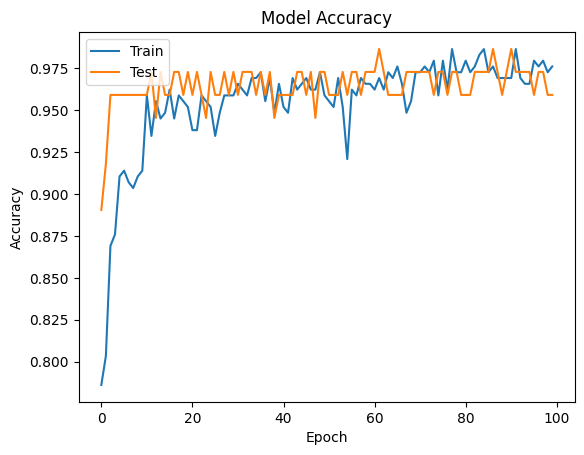

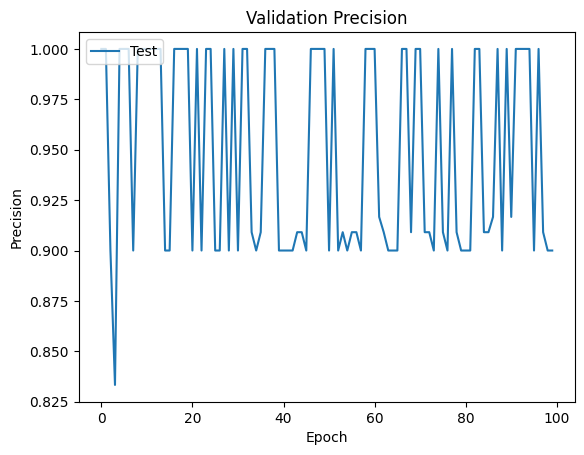

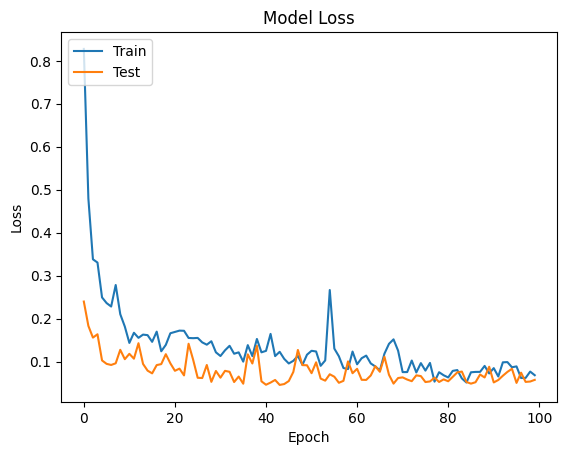

3/3 [==============================] - 0s 38ms/step


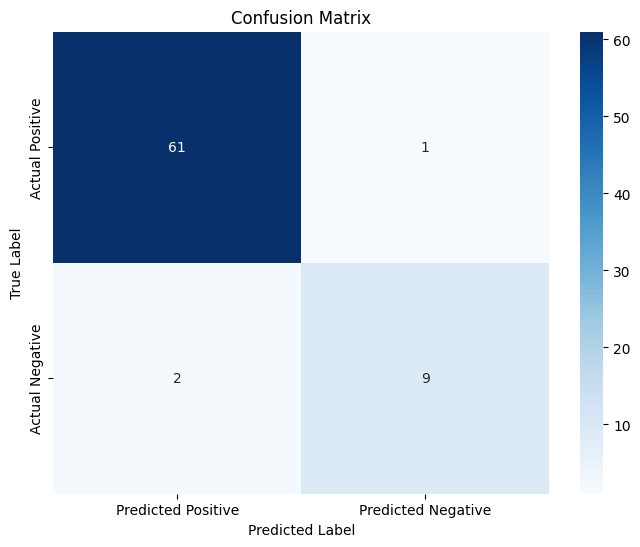

Accuracy: 0.86
Precision: 0.98
Recall: 0.87
F1 Score: 0.92


In [13]:
run_vgg16_transfer_learning()


# run_simple_mlp_autoencoder

Epoch 1/50
14/14 [==============================] - 1s 18ms/step - loss: 0.6034 - val_loss: 0.5373
Epoch 2/50
14/14 [==============================] - 0s 8ms/step - loss: 0.5375 - val_loss: 0.5254
Epoch 3/50
14/14 [==============================] - 0s 7ms/step - loss: 0.5291 - val_loss: 0.5206
Epoch 4/50
14/14 [==============================] - 0s 7ms/step - loss: 0.5258 - val_loss: 0.5198
Epoch 5/50
14/14 [==============================] - 0s 7ms/step - loss: 0.5235 - val_loss: 0.5167
Epoch 6/50
14/14 [==============================] - 0s 8ms/step - loss: 0.5219 - val_loss: 0.5164
Epoch 7/50
14/14 [==============================] - 0s 8ms/step - loss: 0.5217 - val_loss: 0.5161
Epoch 8/50
14/14 [==============================] - 0s 8ms/step - loss: 0.5213 - val_loss: 0.5161
Epoch 9/50
14/14 [==============================] - 0s 7ms/step - loss: 0.5215 - val_loss: 0.5162
Epoch 10/50
14/14 [==============================] - 0s 7ms/step - loss: 0.5211 - val_loss: 0.5158
Epoch 11/50
14/14 

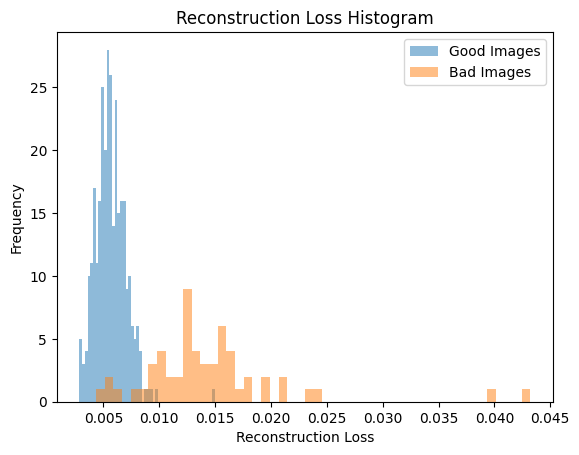

1/1 [==============================] - 0s 20ms/step


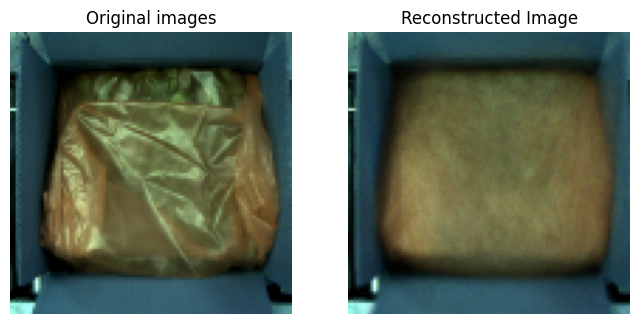

1/1 [==============================] - 0s 18ms/step


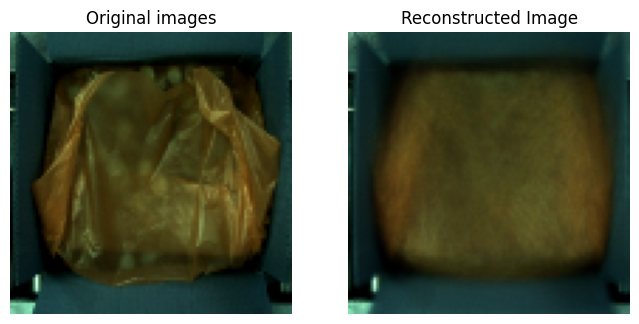

1/1 [==============================] - 0s 17ms/step


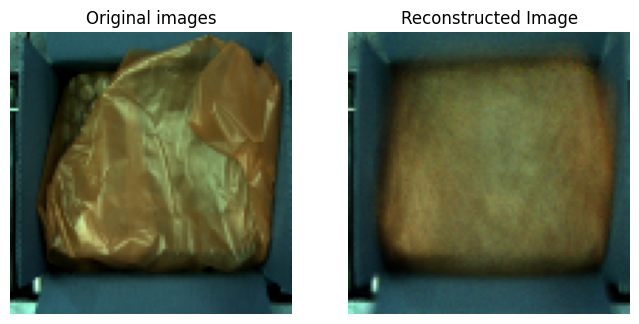

loss for good [0.00535291 0.0028547  0.00561059]
1/1 [==============================] - 0s 17ms/step


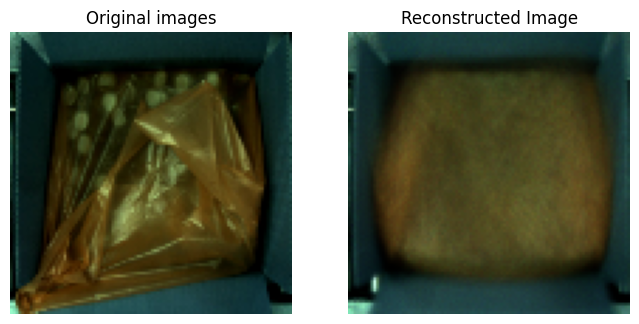

1/1 [==============================] - 0s 21ms/step


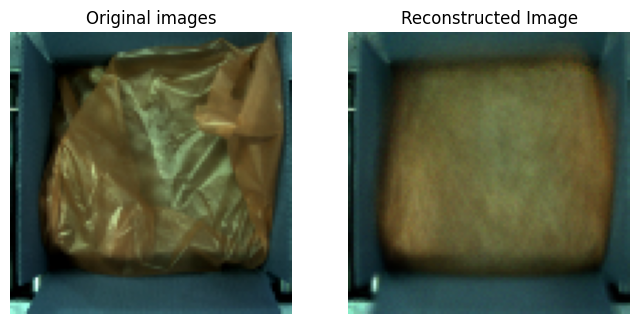

1/1 [==============================] - 0s 19ms/step


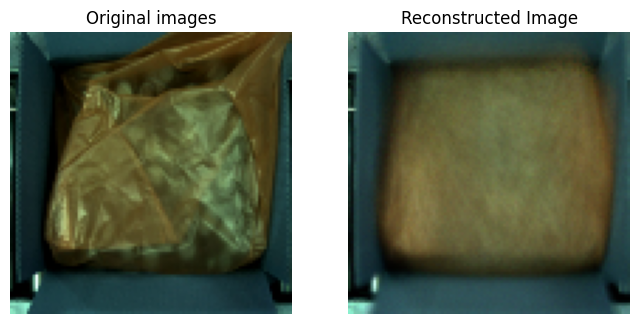

loss for bad [0.00947648 0.00561159 0.00865827]


In [14]:
run_simple_mlp_autoencoder()

# run_cnn_autoencoder

Epoch 1/100
16/16 [==============================] - 5s 72ms/step - loss: 0.6970 - MSE: 0.0693 - MAE: 0.2313 - val_loss: 0.6572 - val_MSE: 0.0272 - val_MAE: 0.1326
Epoch 2/100
16/16 [==============================] - 1s 38ms/step - loss: 0.6209 - MSE: 0.0229 - MAE: 0.1193 - val_loss: 0.6060 - val_MSE: 0.0189 - val_MAE: 0.1084
Epoch 3/100
16/16 [==============================] - 1s 37ms/step - loss: 0.5855 - MSE: 0.0186 - MAE: 0.1053 - val_loss: 0.5758 - val_MSE: 0.0166 - val_MAE: 0.0990
Epoch 4/100
16/16 [==============================] - 1s 38ms/step - loss: 0.5587 - MSE: 0.0158 - MAE: 0.0946 - val_loss: 0.5550 - val_MSE: 0.0140 - val_MAE: 0.0886
Epoch 5/100
16/16 [==============================] - 1s 36ms/step - loss: 0.5384 - MSE: 0.0136 - MAE: 0.0853 - val_loss: 0.5373 - val_MSE: 0.0123 - val_MAE: 0.0820
Epoch 6/100
16/16 [==============================] - 1s 38ms/step - loss: 0.5216 - MSE: 0.0121 - MAE: 0.0794 - val_loss: 0.5370 - val_MSE: 0.0119 - val_MAE: 0.0838
Epoch 7/100
16/1

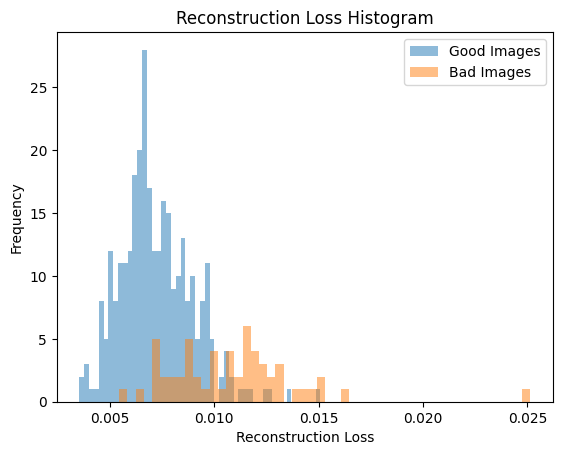

1/1 [==============================] - 0s 37ms/step


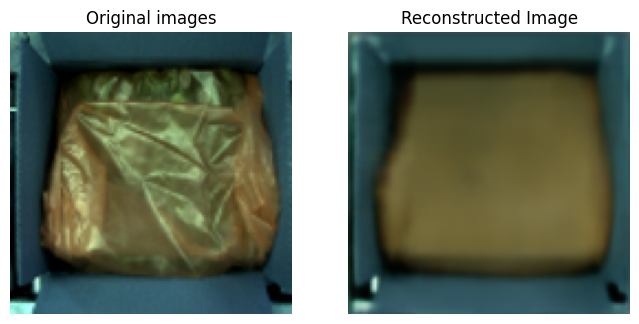

1/1 [==============================] - 0s 36ms/step


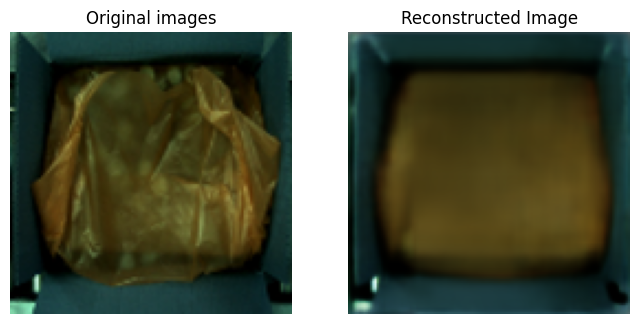

1/1 [==============================] - 0s 38ms/step


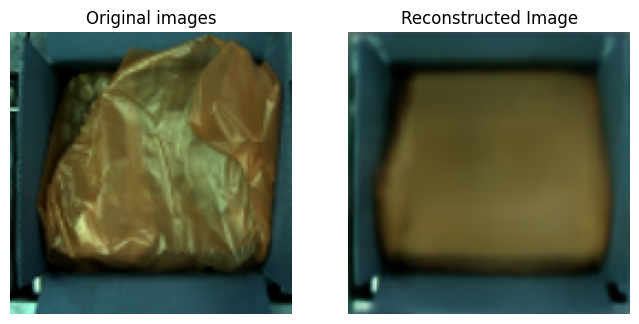

loss for good [0.00787901 0.00355331 0.0096321 ]
1/1 [==============================] - 0s 40ms/step


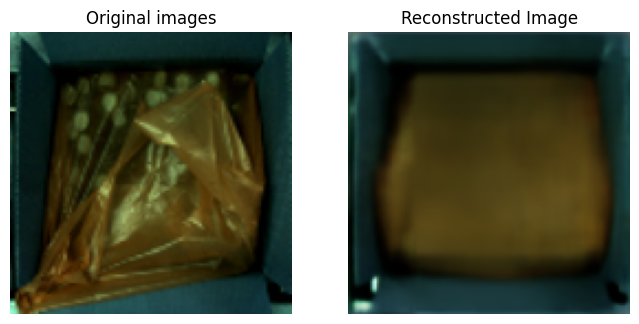

1/1 [==============================] - 0s 38ms/step


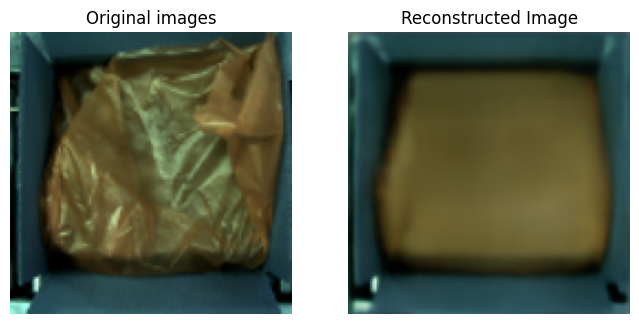

1/1 [==============================] - 0s 55ms/step


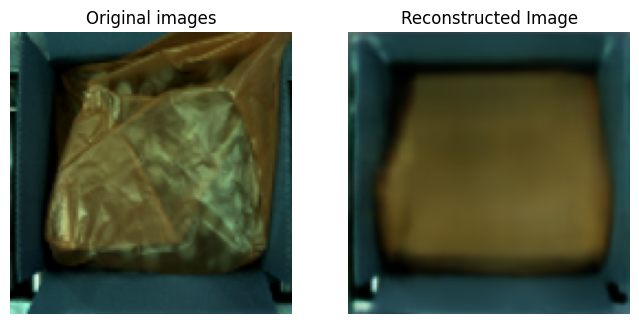

loss for bad [0.00866192 0.00812974 0.00943652]


In [15]:
run_cnn_autoencoder()

# run_cnn_with_vgg16_modified_autoencoder

Epoch 1/50
153/153 [==============================] - 6s 24ms/step - loss: 0.0115 - MSE: 0.0115 - MAE: 0.0798
Epoch 2/50
153/153 [==============================] - 3s 22ms/step - loss: 0.0075 - MSE: 0.0075 - MAE: 0.0646
Epoch 3/50
153/153 [==============================] - 3s 22ms/step - loss: 0.0067 - MSE: 0.0067 - MAE: 0.0602
Epoch 4/50
153/153 [==============================] - 4s 23ms/step - loss: 0.0062 - MSE: 0.0062 - MAE: 0.0574
Epoch 5/50
153/153 [==============================] - 3s 23ms/step - loss: 0.0059 - MSE: 0.0059 - MAE: 0.0557
Epoch 6/50
153/153 [==============================] - 3s 23ms/step - loss: 0.0056 - MSE: 0.0056 - MAE: 0.0541
Epoch 7/50
153/153 [==============================] - 4s 23ms/step - loss: 0.0054 - MSE: 0.0054 - MAE: 0.0529
Epoch 8/50
153/153 [==============================] - 4s 23ms/step - loss: 0.0052 - MSE: 0.0052 - MAE: 0.0517
Epoch 9/50
153/153 [==============================] - 3s 23ms/step - loss: 0.0052 - MSE: 0.0052 - MAE: 0.0519
Epoch 10/5

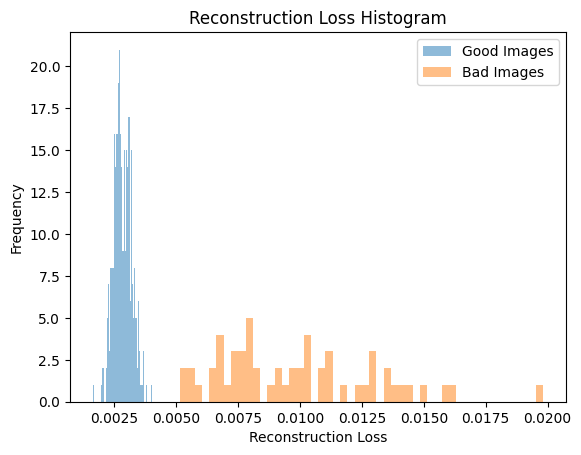

1/1 [==============================] - 0s 361ms/step


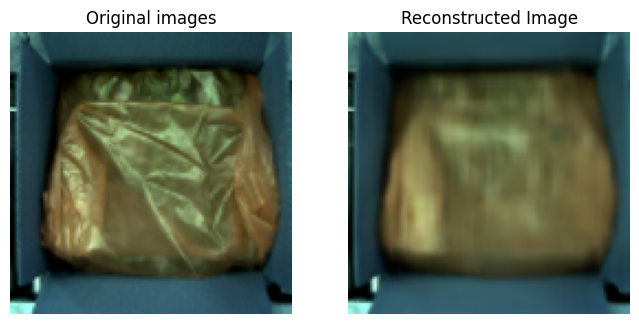

1/1 [==============================] - 0s 355ms/step


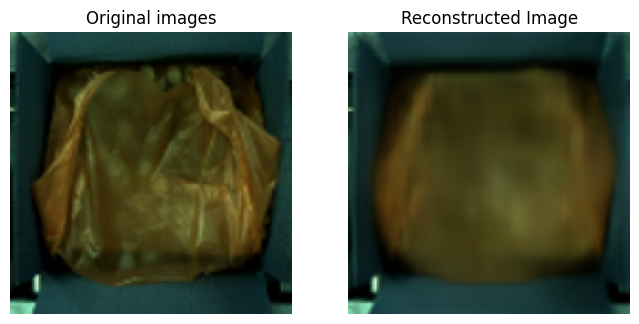

1/1 [==============================] - 0s 334ms/step


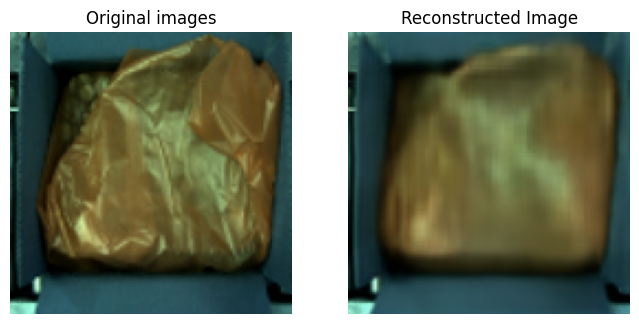

loss for good [0.00292569 0.00209679 0.00252543]
1/1 [==============================] - 0s 375ms/step


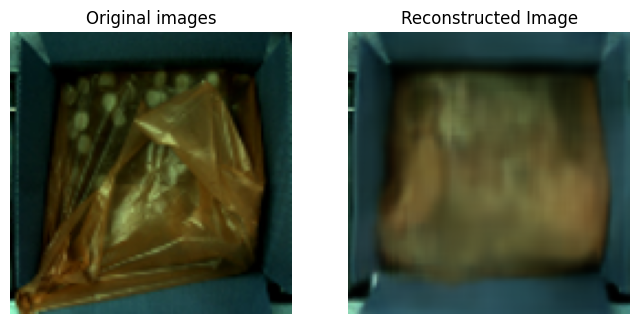

1/1 [==============================] - 0s 336ms/step


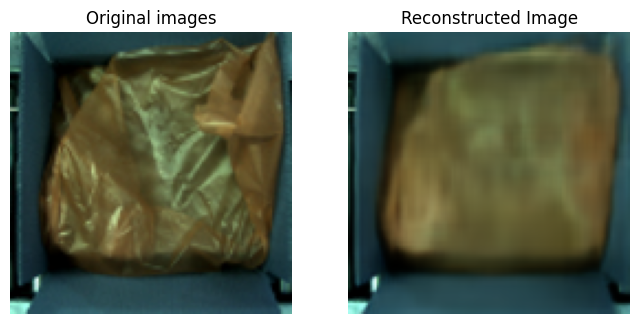

1/1 [==============================] - 0s 364ms/step


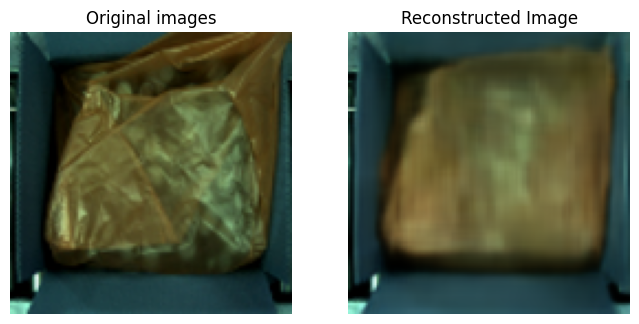

loss for bad [0.01283182 0.00519542 0.00667188]


In [16]:
run_cnn_with_vgg16_modified_autoencoder()